In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install transformers torch torch-geometric sentence-transformers networkx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 11.0 MB/s eta 0:00:00


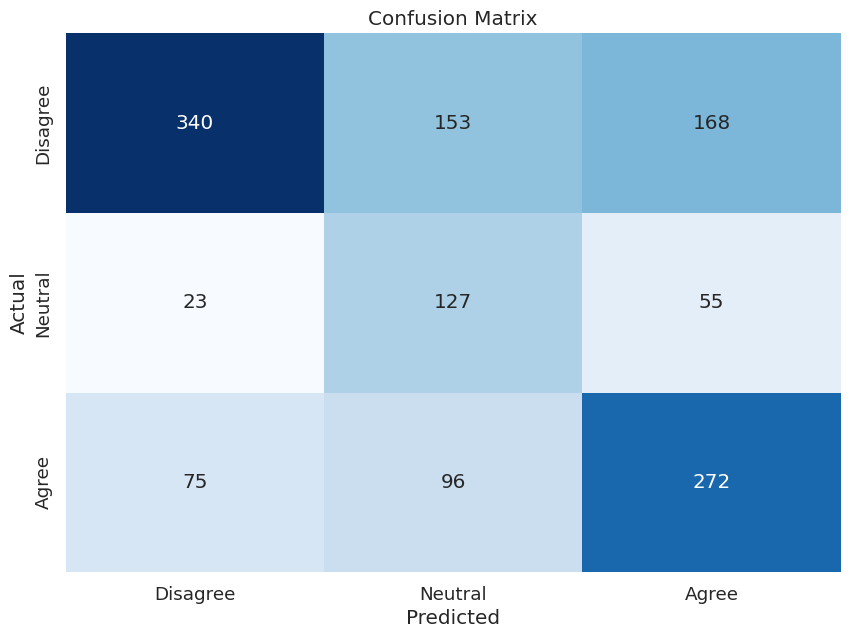

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred)


    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=False, fmt='g', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(ground_truth, predictions, classes=['Disagree', 'Neutral', 'Agree'])


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 1.2243103981018066, Train Acc: 0.37094778520168276, Val Acc: 0.3741339491916859
Epoch 2, Train Loss: 1.1763105392456055, Train Acc: 0.37094778520168276, Val Acc: 0.3741339491916859
Epoch 3, Train Loss: 1.1202950477600098, Train Acc: 0.37094778520168276, Val Acc: 0.3741339491916859
Epoch 4, Train Loss: 1.0709797143936157, Train Acc: 0.37094778520168276, Val Acc: 0.3741339491916859
Epoch 5, Train Loss: 1.019919991493225, Train Acc: 0.37094778520168276, Val Acc: 0.3741339491916859
Epoch 6, Train Loss: 0.9602535963058472, Train Acc: 0.3867854491462509, Val Acc: 0.3920323325635104
Epoch 7, Train Loss: 0.9005585312843323, Train Acc: 0.43330858698341995, Val Acc: 0.4428406466512702
Epoch 8, Train Loss: 0.8532236218452454, Train Acc: 0.4930710220242514, Val Acc: 0.5075057736720554
Epoch 9, Train Loss: 0.8216830492019653, Train Acc: 0.534521158129176, Val Acc: 0.5386836027713626
Epoch 10, Train Loss: 0.7982950210571289, Train Acc: 0.556669141301658, Val Acc: 0.5571593533487

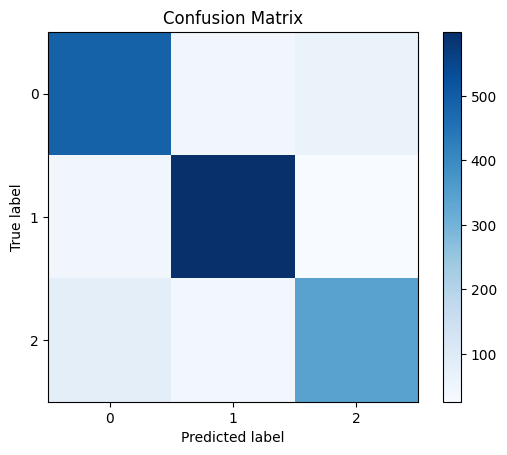

In [5]:
#roberta embedding
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize RoBERTa model and tokenizer
roberta_model = RobertaModel.from_pretrained('roberta-base').to(device)
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


def get_roberta_embeddings(sentences):
    inputs = roberta_tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=50).to(device)
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu()
path = '/content/drive/MyDrive/Labeled Dataset/climateGAT.csv'
df = pd.read_csv(path)

# Oversampling class 1
class_1 = df[df['label'] == 1]
class_0_and_2 = df[df['label'] != 1]

# Calculate the number of samples to duplicate from class 1
target_count = max(class_0_and_2['label'].value_counts())
oversampled_class_1 = class_1.sample(target_count, replace=True)

# Combine back to a single dataframe
df = pd.concat([class_0_and_2, oversampled_class_1], axis=0)

# Shuffle the dataset to mix the oversampled instances
df = df.sample(frac=1).reset_index(drop=True)

# Calculate class weights on the oversampled dataset
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

# batches and get RoBERTa embeddings
batch_size = 128
parent_embeddings_list, child_embeddings_list = [], []

for i in range(0, len(df), batch_size):
    parent_batch = df['body_parent'].tolist()[i:i + batch_size]
    child_batch = df['body_child'].tolist()[i:i + batch_size]
    parent_embeddings_list.append(get_roberta_embeddings(parent_batch))
    child_embeddings_list.append(get_roberta_embeddings(child_batch))

# node features
parent_embeddings = torch.cat(parent_embeddings_list, dim=0)
child_embeddings = torch.cat(child_embeddings_list, dim=0)
node_features = torch.cat((parent_embeddings, child_embeddings, torch.tensor(df['sentiment_parent'].values.reshape(-1, 1), dtype=torch.float), torch.tensor(df['sentiment_child'].values.reshape(-1, 1), dtype=torch.float)), dim=1)

# Create edges
all_msg_ids = pd.concat([df['msg_id_parent'], df['msg_id_child']]).unique()
msg_to_int = {msg: i for i, msg in enumerate(all_msg_ids)}
edges = torch.tensor([(msg_to_int[parent], msg_to_int[child]) for parent, child in zip(df['msg_id_parent'], df['msg_id_child'])], dtype=torch.long).t().contiguous()

# Labels and masks
labels = torch.tensor(df['label'].values, dtype=torch.long)
train_mask = torch.zeros(len(df), dtype=torch.bool)
val_mask = torch.zeros(len(df), dtype=torch.bool)
test_mask = torch.zeros(len(df), dtype=torch.bool)

# Create a single random permutation and then partition it to avoid potential overlap
all_indices = torch.randperm(len(df))
train_indices = all_indices[:int(0.7 * len(df))]
val_indices = all_indices[int(0.7 * len(df)):int(0.85 * len(df))]
test_indices = all_indices[int(0.85 * len(df)):]

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

# Create PyTorch-Geometric data
data = Data(x=node_features, edge_index=edges, y=labels, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data = data.to(device)

# Define the Hybrid Model
class ImprovedHybridModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImprovedHybridModel, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.gat1 = GATConv(in_channels, 64, heads=8, dropout=0.3)
        self.gat2 = GATConv(64 * 8, 64, heads=1, concat=False, dropout=0.3)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 + in_channels, out_channels)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        x = self.bn1(x)
        x_gat = F.dropout(x, p=0.3, training=self.training)
        x_gat = F.elu(self.gat1(x_gat, edge_index))
        x_gat = self.gat2(x_gat, edge_index)
        x_gat = self.bn2(x_gat)
        x_concat = torch.cat((x_gat, x), dim=1)
        x_out = self.fc(x_concat)
        return F.log_softmax(x_out, dim=1)

# Instantiate the model
model = ImprovedHybridModel(node_features.shape[1], 3).to(device)

# Define the optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


class_weights = class_weights.to(device)

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data).detach()
    predictions = logits[mask].max(1)[1].type_as(data.y[mask])
    acc = predictions.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc, predictions.cpu()
# Initialize lists to store metrics
losses = []
train_accuracies = []
val_accuracies = []

n_epochs = 50

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight=class_weights)
    loss.backward()
    optimizer.step()

    # Evaluation
    train_acc, _ = evaluate(model, data, data.train_mask)
    val_acc, _ = evaluate(model, data, data.val_mask)

    # Store metrics
    losses.append(loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}, Train Loss: {loss.item()}, Train Acc: {train_acc}, Val Acc: {val_acc}")

# Final evaluation
acc, predictions = evaluate(model, data, data.test_mask)
predictions = predictions.cpu().numpy()
ground_truth = data.y[data.test_mask].cpu().numpy()

# Classification report
print("\nClassification Report:")
print(classification_report(ground_truth, predictions))

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title="Confusion Matrix", ylabel='True label', xlabel='Predicted label')
    plt.show()

plot_confusion_matrix(ground_truth, predictions, classes=np.unique(df['label']))

In [ ]:
import networkx as nx

# create a GEXF file for Gephi
def create_gexf(df, predictions, msg_to_int):
    G = nx.DiGraph()


    label_meanings = {0: 'disagree', 1: 'neutral', 2: 'agree'}

    # Add nodes with attributes
    for msg_id in df['msg_id_parent'].unique():
        G.add_node(msg_to_int[msg_id],
                   sentiment=df[df['msg_id_parent'] == msg_id].iloc[0]['sentiment_parent'],
                   entity=df[df['msg_id_parent'] == msg_id].iloc[0]['entity'])

    for msg_id in df['msg_id_child'].unique():
        G.add_node(msg_to_int[msg_id],
                   sentiment=df[df['msg_id_child'] == msg_id].iloc[0]['sentiment_child'],
                   entity=df[df['msg_id_child'] == msg_id].iloc[0]['entity'])

    # Add edges with predicted labels and correctness indicator
    for index, row in df.iterrows():
        parent_id = msg_to_int[row['msg_id_parent']]
        child_id = msg_to_int[row['msg_id_child']]
        actual_label = label_meanings.get(row['label'], 'Unknown')
        predicted_label = label_meanings.get(predictions[index], 'Unknown') if index < len(predictions) else actual_label

        # Check if prediction is correct
        is_correct = 'Yes' if predicted_label == actual_label else 'No'

        G.add_edge(parent_id, child_id, prediction=predicted_label, actual_label=actual_label, correct=is_correct)

    # Write to GEXF
    nx.write_gexf(G, '/content/drive/MyDrive/Labeled Dataset/climateGAT_graph.gexf')

# Assuming 'predictions' is a numpy array of your model's predictions on the test set
create_gexf(df, predictions, msg_to_int)


In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=16e91349486515628f9a10f90acf494c8c9e0aa0a67760945174c2a42585f7c2
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


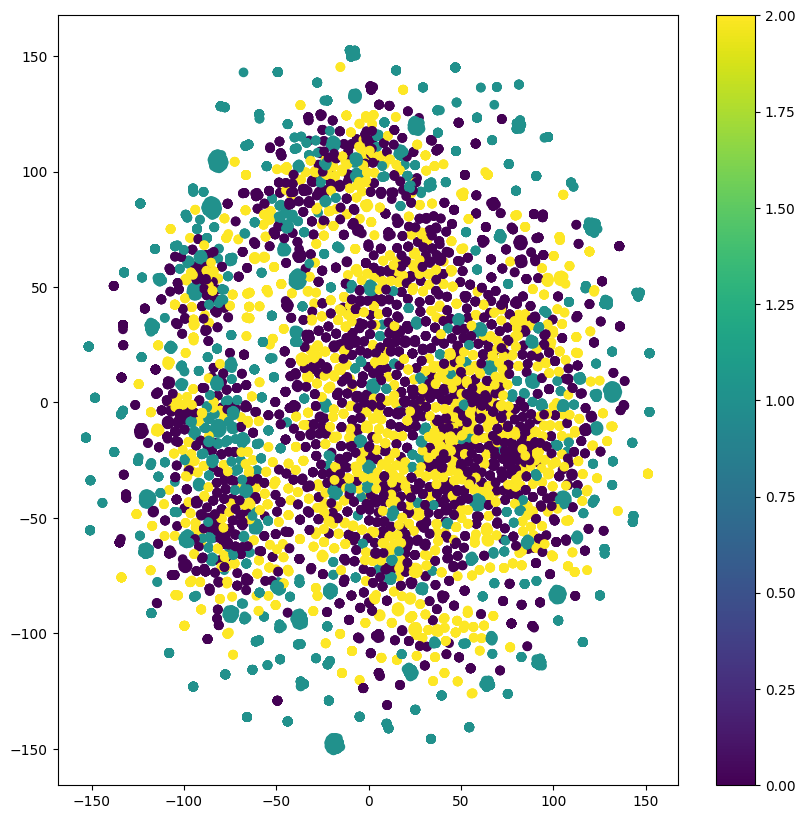

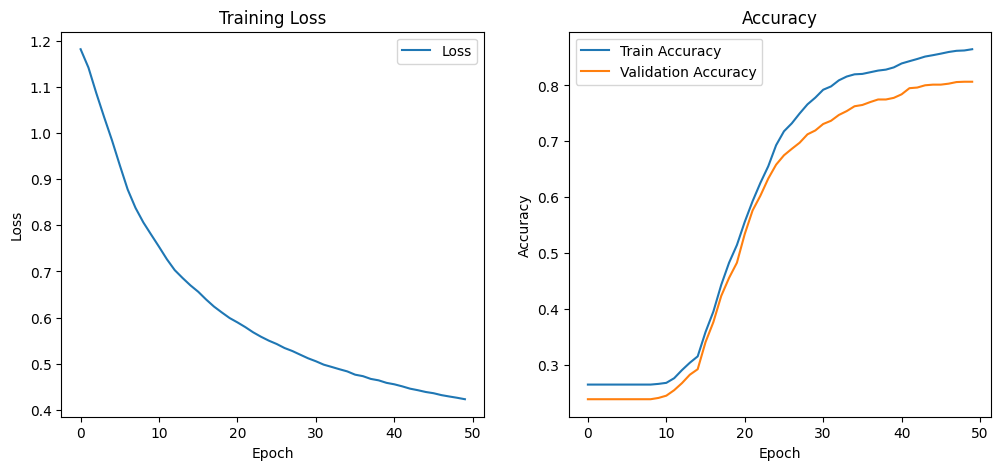

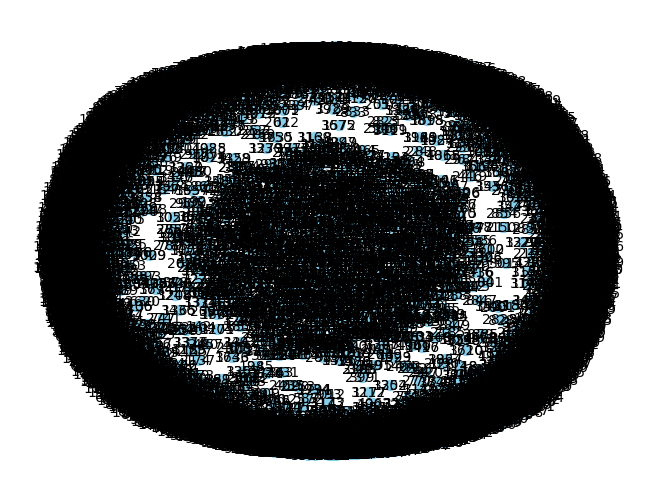

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
node_features = node_features.to(device)
edges = edges.to(device)

def visualize_embeddings(node_features, labels):
    embeddings = node_features.detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.show()

def plot_training_metrics(losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
#static visualization
def visualize_graph_structure(edges):
    G = nx.Graph()
    for i in range(node_features.shape[0]):
        G.add_node(i)

    for i in range(edges.shape[1]):
        source, target = edges[:, i]
        G.add_edge(source.item(), target.item())

    nx.draw(G, with_labels=True, node_size=50, node_color="skyblue", font_size=10)
    plt.show()

# Execute the visualizations
visualize_embeddings(node_features, df['label'])
plot_training_metrics(losses, train_accuracies, val_accuracies)
visualize_graph_structure(edges)


In [ ]:
!pip install pyvis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00


In [ ]:
from pyvis.network import Network
import json
from IPython.display import HTML, display

def visualize_graph_structure_interactive(edges):
    G = Network(notebook=True, height="750px", width="100%")
    G.add_nodes(range(node_features.shape[0]))  # Adding nodes

    for i in range(edges.shape[1]):
        source, target = edges[:, i]
        G.add_edge(int(source.item()), int(target.item()))

    # Set options for a better layout
    options = {
        "nodes": {
            "shape": "dot",
            "size": 10,
            "font": {
                "size": 12,
                "color": "#ffffff"
            },
            "borderWidth": 2
        },
        "edges": {
            "width": 0.5
        },
        "physics": {
            "forceAtlas2Based": {
                "gravitationalConstant": -30,
                "centralGravity": 0.005,
                "springLength": 100,
                "springConstant": 0.18
            },
            "maxVelocity": 146,
            "solver": "forceAtlas2Based",
            "timestep": 0.35,
            "stabilization": {"iterations": 150}
        }
    }

    options_json = json.dumps(options)
    G.set_options(options_json)

    # Generate and display the network graph
    G.show("graph.html")
    display(HTML("graph.html"))

# Calling the function
visualize_graph_structure_interactive(data.edge_index)


graph.html


In [ ]:
import plotly.graph_objects as go
import networkx as nx

def visualize_graph_with_plotly(edges):
    # Create a networkx graph from the edge index
    G = nx.Graph()
    for i in range(edges.shape[1]):
        source, target = edges[:, i]
        G.add_edge(int(source.item()), int(target.item()))

    # Extract node positions using a layout algorithm
    pos = nx.spring_layout(G)

    # Create edge traces
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Create node traces
    node_x = [pos[node][0] for node in G.nodes()]
    node_y = [pos[node][1] for node in G.nodes()]

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            color=[],
            line_width=2))

    # Create figure
    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title='<br>Network graph made with Python',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[dict(
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )

    fig.show()

# Calling the function
visualize_graph_with_plotly(data.edge_index)


In [4]:

#ablation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


roberta_model = RobertaModel.from_pretrained('roberta-base').to(device)
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


def get_roberta_embeddings(sentences):
    inputs = roberta_tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=50).to(device)
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu()
path = '/content/drive/MyDrive/Labeled Dataset/climateGAT.csv'
df = pd.read_csv(path)

# Oversampling class 1
class_1 = df[df['label'] == 1]
class_0_and_2 = df[df['label'] != 1]

# Calculate the number of samples to duplicate from class 1
target_count = max(class_0_and_2['label'].value_counts())
oversampled_class_1 = class_1.sample(target_count, replace=True)

# Combine back to a single dataframe
df = pd.concat([class_0_and_2, oversampled_class_1], axis=0)


df = df.sample(frac=1).reset_index(drop=True)

# Calculate class weights on the oversampled dataset
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

# batches and get RoBERTa embeddings
batch_size = 128
parent_embeddings_list, child_embeddings_list = [], []

for i in range(0, len(df), batch_size):
    parent_batch = df['body_parent'].tolist()[i:i + batch_size]
    child_batch = df['body_child'].tolist()[i:i + batch_size]
    parent_embeddings_list.append(get_roberta_embeddings(parent_batch))
    child_embeddings_list.append(get_roberta_embeddings(child_batch))

# node features
parent_embeddings = torch.cat(parent_embeddings_list, dim=0)
child_embeddings = torch.cat(child_embeddings_list, dim=0)
node_features = torch.cat((parent_embeddings, child_embeddings, torch.tensor(df['sentiment_parent'].values.reshape(-1, 1), dtype=torch.float), torch.tensor(df['sentiment_child'].values.reshape(-1, 1), dtype=torch.float)), dim=1)

# Create edges
all_msg_ids = pd.concat([df['msg_id_parent'], df['msg_id_child']]).unique()
msg_to_int = {msg: i for i, msg in enumerate(all_msg_ids)}
edges = torch.tensor([(msg_to_int[parent], msg_to_int[child]) for parent, child in zip(df['msg_id_parent'], df['msg_id_child'])], dtype=torch.long).t().contiguous()

# Labels and masks
labels = torch.tensor(df['label'].values, dtype=torch.long)
train_mask = torch.zeros(len(df), dtype=torch.bool)
val_mask = torch.zeros(len(df), dtype=torch.bool)
test_mask = torch.zeros(len(df), dtype=torch.bool)

# Create a single random permutation and then partition it to avoid potential overlap
all_indices = torch.randperm(len(df))
train_indices = all_indices[:int(0.7 * len(df))]
val_indices = all_indices[int(0.7 * len(df)):int(0.85 * len(df))]
test_indices = all_indices[int(0.85 * len(df)):]

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True


data = Data(x=node_features, edge_index=edges, y=labels, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data = data.to(device)


class ImprovedHybridModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImprovedHybridModel, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.gat1 = GATConv(in_channels, 64, heads=8, dropout=0.3)
        self.gat2 = GATConv(64 * 8, 64, heads=1, concat=False, dropout=0.3)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 + in_channels, out_channels)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        x = self.bn1(x)
        x_gat = F.dropout(x, p=0.3, training=self.training)
        x_gat = F.elu(self.gat1(x_gat, edge_index))
        x_gat = self.gat2(x_gat, edge_index)
        x_gat = self.bn2(x_gat)
        x_concat = torch.cat((x_gat, x), dim=1)
        x_out = self.fc(x_concat)
        return F.log_softmax(x_out, dim=1)

def remove_features(features, start_idx, end_idx):
    return torch.cat([features[:, :start_idx], features[:, end_idx:]], dim=1)

# Calculate start and end indices for each feature set
parent_embedding_end_idx = parent_embeddings.shape[1]
child_embedding_start_idx = parent_embedding_end_idx
child_embedding_end_idx = child_embedding_start_idx + child_embeddings.shape[1]
parent_sentiment_idx = child_embedding_end_idx
child_sentiment_idx = parent_sentiment_idx + 1

# Ablation feature sets
ablation_feature_sets = {
    'Without Parent Embeddings': remove_features(node_features, 0, parent_embedding_end_idx),
    'Without Child Embeddings': remove_features(node_features, child_embedding_start_idx, child_embedding_end_idx),
    'Without Parent Sentiment': remove_features(node_features, parent_sentiment_idx, parent_sentiment_idx + 1),
    'Without Child Sentiment': remove_features(node_features, child_sentiment_idx, child_sentiment_idx + 1),
    'Without Parent & Child Sentiment': torch.cat((parent_embeddings, child_embeddings), dim=1),
    'Without Parent & Child Embeddings': torch.cat((torch.tensor(df['sentiment_parent'].values.reshape(-1, 1), dtype=torch.float), torch.tensor(df['sentiment_child'].values.reshape(-1, 1), dtype=torch.float)), dim=1)
}


for key in ablation_feature_sets.keys():
    ablation_feature_sets[key] = ablation_feature_sets[key].to(device)


class_weights = class_weights.to(device)


# Ablation study
for feature_name, ablated_features in ablation_feature_sets.items():
    print(f"\nAblation Study: {feature_name}")


    ablated_data = Data(x=ablated_features, edge_index=edges, y=labels, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask).to(device)


    model = ImprovedHybridModel(ablated_features.shape[1], 3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.015, weight_decay=1e-4)

    n_epochs = 50
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(ablated_data)
        loss = F.nll_loss(out[ablated_data.train_mask], ablated_data.y[ablated_data.train_mask], weight=class_weights)
        loss.backward()
        optimizer.step()

        # Evaluation for each ablated feature set
        train_acc, _ = evaluate(model, ablated_data, ablated_data.train_mask)
        val_acc, _ = evaluate(model, ablated_data, ablated_data.val_mask)
        print(f"Epoch {epoch}, Train Loss: {loss.item()}, Train Acc: {train_acc}, Val Acc: {val_acc}")

    acc, predictions = evaluate(model, ablated_data, ablated_data.test_mask)
    predictions = predictions.cpu().numpy()
    ground_truth = ablated_data.y[ablated_data.test_mask].cpu().numpy()


    print("\nClassification Report:")
    print(classification_report(ground_truth, predictions))






Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Ablation Study: Without Parent Embeddings


NameError: name 'evaluate' is not defined